In [2]:
import numpy as np

import matplotlib.pyplot as plt

from utils import *
from collaborative_beamforming import *

In [3]:
side_of_region = 1000.
side_resolution = 20.
min_dist = 100
num_antennas = 20
wavelength = 1.

def place_antennas_around_station(station_position, distance_to_center=0.2, num_antennas=num_antennas):
    p = []
    angle_antennas = np.linspace(0, 2*np.pi, num_antennas)
    for angle in angle_antennas:
        p.append(station_position + distance_to_center * np.array([np.cos(angle), np.sin(angle)]))
    p = np.vstack(p)
    return p

In [53]:
station_positions = np.array([
    [side_of_region//2, min_dist],
    # [side_of_region - min_dist, side_of_region//2],
    [min_dist, side_of_region//2],
    [side_of_region//2, side_of_region - min_dist]
])

antenna_positions = []
for s in station_positions:
    antenna_positions.append(place_antennas_around_station(s))

user_to_station_distance = 200

user_positions_initial = [

    # Closer to [min_dist, side_of_region//2]
    [min_dist + user_to_station_distance, side_of_region//2 - 2],
    [min_dist + user_to_station_distance, side_of_region//2 + 2],
    [min_dist + user_to_station_distance, side_of_region//2],
    [min_dist, side_of_region//2 + user_to_station_distance],
    [min_dist, side_of_region//2 + user_to_station_distance + 1],
    [min_dist - 1, side_of_region//2 + user_to_station_distance + 1],
    [min_dist, side_of_region//2 + user_to_station_distance -1],
    [min_dist - 1, side_of_region//2 + user_to_station_distance + 2],
    [min_dist, side_of_region//2 + user_to_station_distance + 3],
    [min_dist - 1, side_of_region//2 + user_to_station_distance + 4],

    # Closer to [side_of_region//2, min_dist]
    [side_of_region//2 - 3 * user_to_station_distance, min_dist + 1],
    [side_of_region//2 - user_to_station_distance, min_dist - 1],
    [side_of_region//2 - user_to_station_distance, min_dist],
    [side_of_region//2 + 2 * user_to_station_distance, min_dist + 1],
    [side_of_region//2 + user_to_station_distance, min_dist - 2],
    [side_of_region//2 + user_to_station_distance, min_dist + 3],

    # Closer to [side_of_region//2, side_of_region - min_dist]
    [side_of_region//2 + 36, side_of_region - min_dist - user_to_station_distance],
    [side_of_region//2 + 24, side_of_region - min_dist - user_to_station_distance - 1],
    [side_of_region//2 + 26, side_of_region - min_dist - user_to_station_distance + 2],
    [side_of_region//2 + 28, side_of_region - min_dist - user_to_station_distance + 1],
]

In [54]:
user_positions = []
for user in user_positions_initial:
    t = np.array(user)
    user_positions.append(t)
    user_positions.append(t - np.array([0, 5]))
    user_positions.append(t + np.array([3, -5]))
    user_positions.append(t - np.array([0, 5]))
    user_positions.append(t + np.array([-3, -2]))
    user_positions.append(t - np.array([0, 5]))
    user_positions.append(t + np.array([14, 20]))
    user_positions.append(t - np.array([28, 18]))
    user_positions.append(t + np.array([-3, -20]))

user_positions = np.array(user_positions)

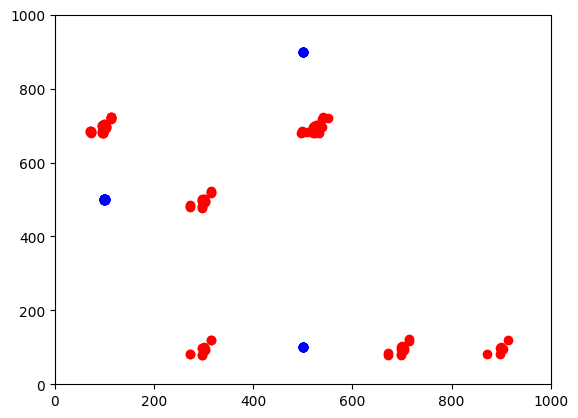

In [55]:
stacked_antenna_positions = np.vstack(antenna_positions)

plt.plot(stacked_antenna_positions[:,0],
         stacked_antenna_positions[:,1],
         'bo',
         user_positions[:,0],
         user_positions[:,1],
         'ro'
         )
plt.xlim(0, side_of_region)
plt.ylim(0, side_of_region)
plt.show()

In [56]:
cov_per_station = []
station_user_positions = []
for idx, ant in enumerate(antenna_positions):
    station_user_position = user_positions - station_positions[idx]
    station_user_position = (station_user_position.T/np.linalg.norm(station_user_position, axis=1)).T
    station_user_positions.append(station_user_position)
    cov_per_station.append(generate_covariance_matrix(ant, station_user_position, noise_level=1.5))

cov_of_stations = generate_covariance_matrix(
    station_positions,
    user_positions,
    user_intensities=70 * np.ones(len(user_positions)),
    noise_level=1.5)

In [57]:
closest_station_indices = []
for user in user_positions:
    closest_station_indices.append(np.argmin(np.linalg.norm(user - station_positions, axis=1)))

In [58]:
beamforming_weights, thetas = collaborative_flexibeam(
    antenna_positions,
    station_positions,
    side_of_region,
    side_resolution,
    cov_per_station,
    cov_of_stations,
    4,
    wavelength=wavelength,
)

INFO -- [2023-05-31 20:36:30.411714] Iteration 0
	iteration: 0
	RelError[x]: 0.0
ERROR -- [2023-05-31 20:36:30.418185] Something went wrong -> EXCEPTION RAISED
Traceback (most recent call last):
  File "/home/dicedead/Courses/DS_MA/SSDP_MA2/project/5G_throughput_opti/src/pycsou/runtime/__init__.py", line 223, in coerce
    raise
RuntimeError: No active exception to reraise

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dicedead/Courses/DS_MA/SSDP_MA2/project/5G_throughput_opti/src/pycsou/abc/solver.py", line 624, in _step
    self.m_step()
  File "/home/dicedead/Courses/DS_MA/SSDP_MA2/project/5G_throughput_opti/src/pycsou/opt/solver/pgd.py", line 169, in m_step
    z = pycu.copy_if_unsafe(self._f.grad(y))
                            ^^^^^^^^^^^^^^^
  File "/home/dicedead/Courses/DS_MA/SSDP_MA2/project/5G_throughput_opti/src/pycsou/runtime/__init__.py", line 173, in wrapper
    out = func(**func_args)
          ^^^^

[2023-05-31 20:36:30.418185] Something went wrong -> EXCEPTION RAISED
More information: /tmp/pycsou_g7pu4om9/solver.log.


In [59]:
def cartesian_to_arg(cartesian_coords):
    return np.angle(cartesian_coords[0] + cartesian_coords[1] * 1j)

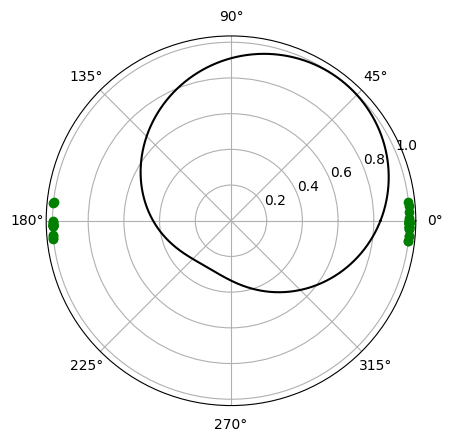

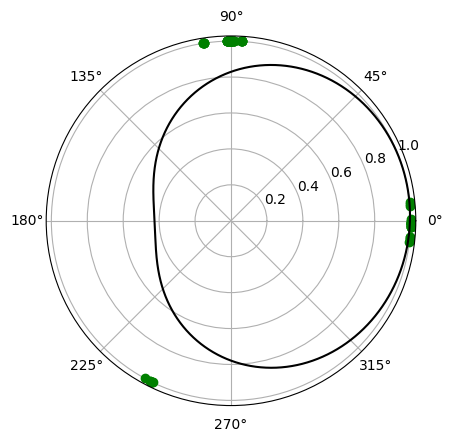

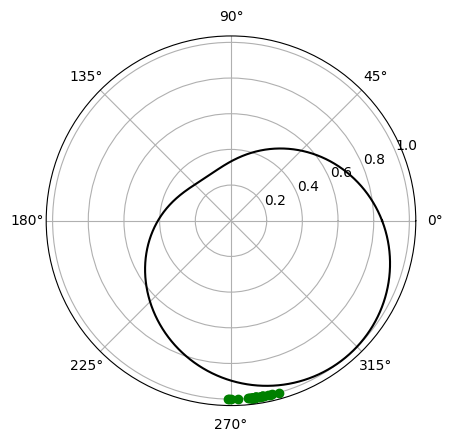

In [60]:
for s in range(len(beamforming_weights)):
    tmp = station_user_positions[s][np.isclose(closest_station_indices, s)]
    plt.polar(list(map(cartesian_to_arg, tmp)), np.ones(len(tmp)), "go", thetas[s], beamforming_weights[s]/np.max(beamforming_weights[s]), '-k')
    plt.show()